In [146]:
import sys
import os

import numpy as np
import scipy as sp
#import scipy.signal as sig

import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

import matplotlib.cm as cm

import cvxopt

import cvxpy as cvx

%matplotlib notebook


status: optimal
optimal value 2253.07829826
(2, 10)


<IPython.core.display.Javascript object>


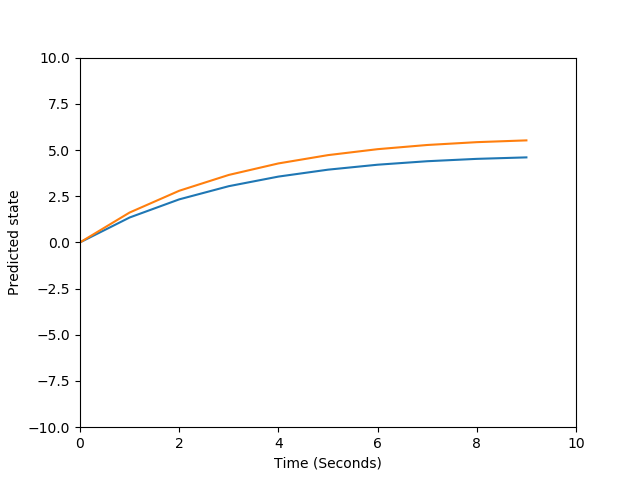

<IPython.core.display.Javascript object>


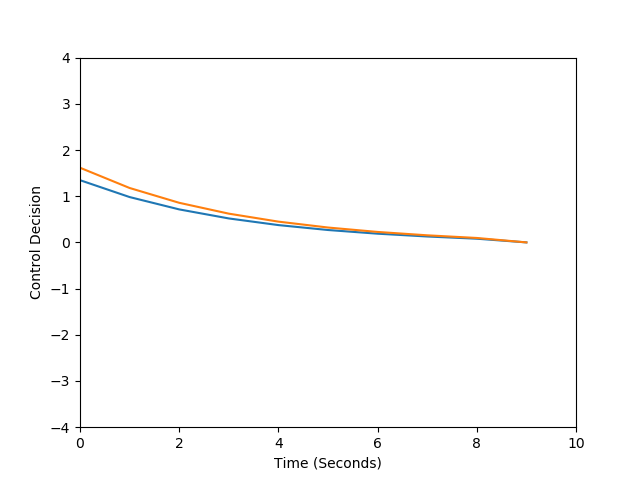

In [147]:
T = 10 # seconds, the time horizon of optimisation 
dt = 1 #seconds, the time step of optimisation 

#size of the storage for all the values of different signals
ssize = int(T/dt) 

# x_i is added as a vector of variables to the problem 
x_pred = cvx.Variable(  2,ssize )



# u_i is added as a vector of variables to the problem 
u_plan = cvx.Variable( 2,ssize)

# adding the state space constraints  
constraints = [ ]

#adding the initial conditions
constraints.append (x_pred[:,0] == [0,0])
#constraints.append (u_plan[:,0] == [0,0])

constraints.append (x_pred <= 10)
constraints.append (x_pred >= -10)

constraints.append (u_plan <= 3)
constraints.append (u_plan >= -3)


for i in range (ssize-1):
    constraints.append (x_pred[:,i+1] == x_pred[:,i] + u_plan[:,i])
    
    

# the time-varying part of cost is m*(x - target) 
# m starts low and keeps building up if target is not approached
m = 0
target = [-7,-7]
# if target is acheived there is more tendency to go home via the cost n*(x-home)
n = 10
home = [5,6]


# objective function
ObjFunc =   cvx.Minimize(  sum(
                                cvx.norm(n* u_plan[:,i], 2)**2 +
                                n * cvx.norm(x_pred[:,i]-home,2)**2 +
                                m * cvx.norm(x_pred[:,i]-target,2)**2
                           for i in range(ssize)) + 
                           n * cvx.norm(x_pred[:,-1]-home,2)**2 
                        )

prob = cvx.Problem(ObjFunc, constraints)
prob.solve() 
print "status:", prob.status
print "optimal value", prob.value
print np.shape(x_pred.value)


fig1a = plt.figure()
plt.plot(x_pred.value.T )
plt.ylabel('Predicted state')
plt.xlabel('Time (Seconds)')
plt.axis([0, ssize, -10, 10])
plt.show()

fig1b = plt.figure()
plt.plot(u_plan.value.T)
plt.ylabel('Control Decision')
plt.xlabel('Time (Seconds)')
plt.axis([0, ssize, -4, 4])
plt.show()





## MPC Strategy 


In [148]:


# actual simulation time horizon 
T_Sim = 200

# size of the storage variables dt is the same as the time step for point optimisation
size_Sim = int (T_Sim/dt )

# the horizon for planning/optimisation
T_Opt = 2

# initialising the storage array for the variables of the problem
x_sim = np.zeros((2, size_Sim))
x_sim_0  = np.zeros((1, 2))
x_sim[:,0] = x_sim_0 


x_pred_sim = np.zeros((2, size_Sim))
x_pred_sim_0  = np.zeros((1, 2))
x_pred_sim[:,0] = x_pred_sim_0 

u_sim = np.ones((2, size_Sim))
u_sim_0  = np.zeros((1, 2))
u_sim[:,0] = u_sim_0 



# this is the main loop of the simulation 
i = 0
# index of time since reset happened
l = 0
while (i <= size_Sim - T_Opt - 1):
    
    
    # replace the initial conditions for the solver
    

    prob.constraints[0] = (x_pred[0,0] == x_sim[0,i])
    prob.constraints[1] = (x_pred[1,0] == x_sim[1,i])
    #prob.constraints[2] = (u_plan[0,0] == u_sim[0,i])
    #prob.constraints[3] = (u_plan[1,0] == u_sim[1,i])

    
    
    
    
    #solve for the next N steps
    prob.solve()
    
    # this is the execution loop of the simulation in which for T_Opt steps
    # the plan of the planner is applied to the simulated system
    for j in range (T_Opt - 1):
        
        
        #reading the plan from the solver 
        u_sim[:,i+j] = (u_plan.value[:,j]).T
        
        
        #disturbance signal randint returns uniformly probable an integer between [lower upper) upper not included.  
        d = 0 * np.random.uniform(-.5,.6,[1,2]) 
        
        
        # how the actual system is simulated 
        x_sim[:,i+j+1] = x_sim[:,i+j] + u_sim[:,i+j] + d 
        
        
        
        # storing what the planner had predicted for the states
        x_pred_sim[:,i+j+1] = (x_pred.value[:,j+1]).T
        
        
    
    # house keeping for the interplay of the inner and outer loop (you can ignore these)
    i = i + T_Opt - 1    
    #u_sim[:,i] = u_sim[:,i - 1]
    print np.linalg.norm(x_sim[:,i]-target,2)
    
    if (np.linalg.norm(x_sim[:,i]-target,2) > 1):
        m = m + .1 * (i - l + 1)
    else:
        l = i
        m = 0
        
    prob.objective =  cvx.Minimize (sum(
                                        cvx.norm(1* u_plan[:,k], 2)**2 +
                                        n* cvx.norm(x_pred[:,k]-home,2)**2 +
                                        m * cvx.norm(x_pred[:,k]-target,2)**2
                                    for k in range(ssize)) + 
                                    n * cvx.norm(x_pred[:,-1]-home,2)**2 )
                        
    
    
    





11.9961122282
16.2383576668
16.7996605284
16.2753613143
15.5758800678
14.8029611281
13.9901792076
13.1623778835
12.3396158128
11.5372687499
10.7664778553
10.034613445
9.34599204245
8.70258388057
8.10460952876
7.55106432718
7.04007643515
6.56934775669
6.13624397423
5.73799871344
5.37193538992
5.03539081089
4.72585896397
4.44100299716
4.1786508909
3.93677191368
3.71357272123
3.50733029913
3.31658203085
3.1399227024
2.97613648576
2.82406424209
2.68269744402
2.55112211267
2.42851592258
2.31412627746
2.20728274262
2.10734449182
2.01377266549
1.92606180541
1.84374503287
1.76641906892
1.69370024804
1.62523822447
1.56069628384
1.49981700532
1.44234117449
1.38801930489
1.33662299092
1.28796570144
1.24185425775
1.19812034723
1.15660035751
1.11715724458
1.07965422678
1.0439625883
1.00999975016
0.977627095555
5.21963291843
9.4622080392
13.7048237483
16.0333066609
15.5577097636
14.8016526623
13.9900902108
13.162372079
12.3396154222
11.5372687283
10.7664778536
10.034613445
9.34599204223
8.7025838805

<IPython.core.display.Javascript object>


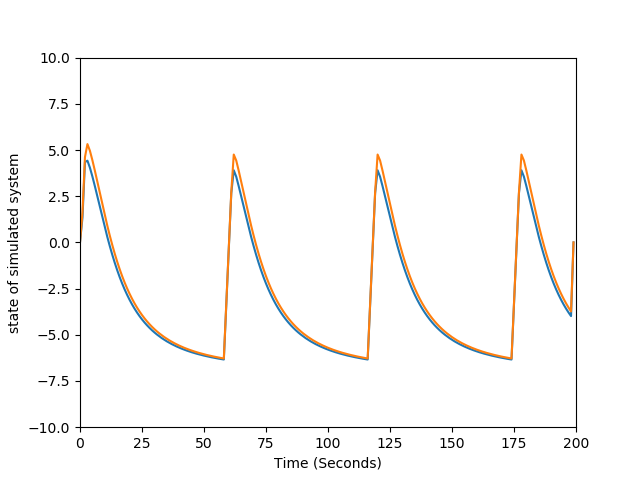

<IPython.core.display.Javascript object>


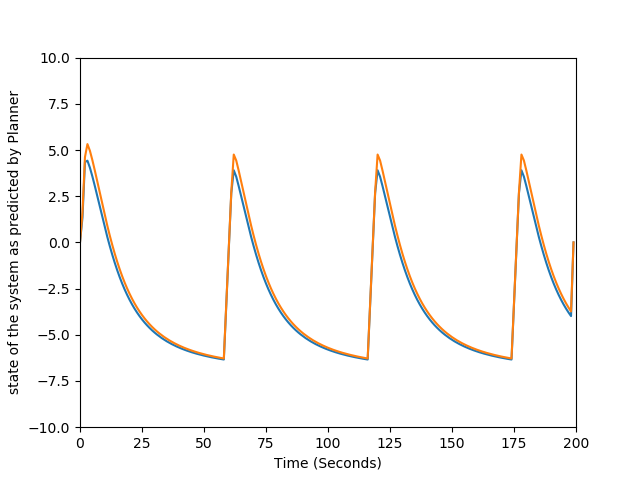

<IPython.core.display.Javascript object>


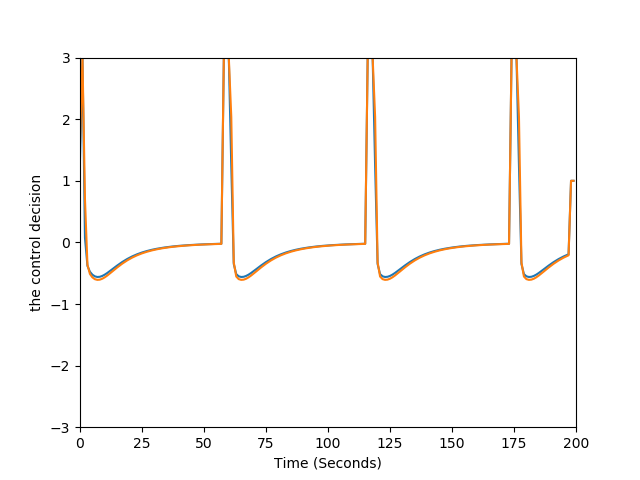

In [149]:
# Plotting the results
fig2 = plt.figure()
plt.plot(x_sim.T)
plt.ylabel('state of simulated system')
plt.xlabel('Time (Seconds)')
plt.axis([0, size_Sim, -10, 10])
plt.show()

fig2b = plt.figure()
plt.plot(x_pred_sim.T)
plt.ylabel('state of the system as predicted by Planner')
plt.xlabel('Time (Seconds)')
plt.axis([0, size_Sim, -10, 10])
plt.show()

fig2c = plt.figure()
plt.plot(u_sim.T)
plt.ylabel('the control decision')
plt.xlabel('Time (Seconds)')
plt.axis([0, size_Sim, -3, 3])
plt.show()



<IPython.core.display.Javascript object>


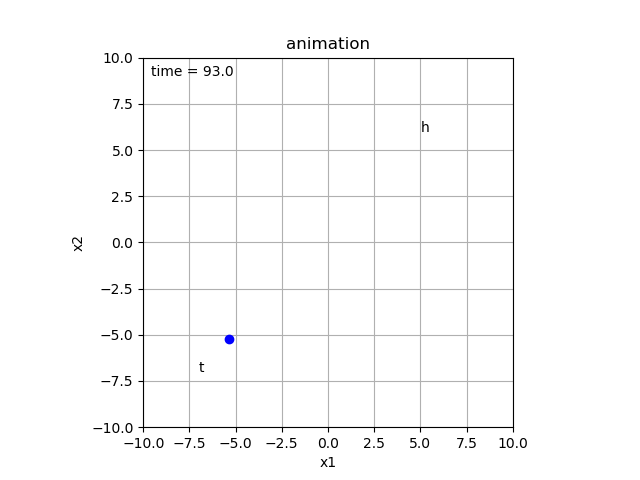

In [150]:
# Animation 





def update_line(num, data, line):
#     line.set_data(data[..., :num])
    line.set_data(data[:,num])
    time_text.set_text('time = %.1f' % num)
    home_text.set_text('h')
    target_text.set_text('t')
    
    return line, time_text, home_text, target_text

fig3 = plt.figure()
ax = fig3.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-10, 10), ylim=(-10, 10))
ax.grid()
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
home_text = ax.text(.75,.80, '', transform=ax.transAxes)
target_text = ax.text(.15,.15, '', transform=ax.transAxes)

data = x_sim

l, = plt.plot( [], 'b-o', linewidth=4)
# plt.xlim(-10, 10)
# plt.ylim(-10, 10)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('animation')

line_ani = animation.FuncAnimation(fig3, update_line, size_Sim, fargs=(data, l),
                                   interval=100, blit=True)
#HTML(line_ani.to_jshtml())